# Modélisation épidémiologique SIRD avec méthode d'Euler


Ce notebook contient l'implémentation complète d'une simulation du modèle SIRD (Susceptibles, Infectés, Rétablis, Décédés) en utilisant la méthode d'Euler, ainsi qu'une optimisation des paramètres par Grid Search.


## Étape 1 : Implémentation du modèle SIRD avec la méthode d’Euler"

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from itertools import product

# Méthode d’Euler pour le modèle SIRD
def euler_sird(beta, gamma, mu, S0, I0, R0, D0, dt, days):
    N = int(days / dt)
    S, I, R, D = [S0], [I0], [R0], [D0]
    for _ in range(N):
        S_new = S[-1] - dt * beta * S[-1] * I[-1]
        I_new = I[-1] + dt * (beta * S[-1] * I[-1] - gamma * I[-1] - mu * I[-1])
        R_new = R[-1] + dt * gamma * I[-1]
        D_new = D[-1] + dt * mu * I[-1]
        S.append(S_new)
        I.append(I_new)
        R.append(R_new)
        D.append(D_new)
    t = np.linspace(0, days, N + 1)
    return t, np.array(S), np.array(I), np.array(R), np.array(D)


## Étape 2 : Simulation et tracé des courbes

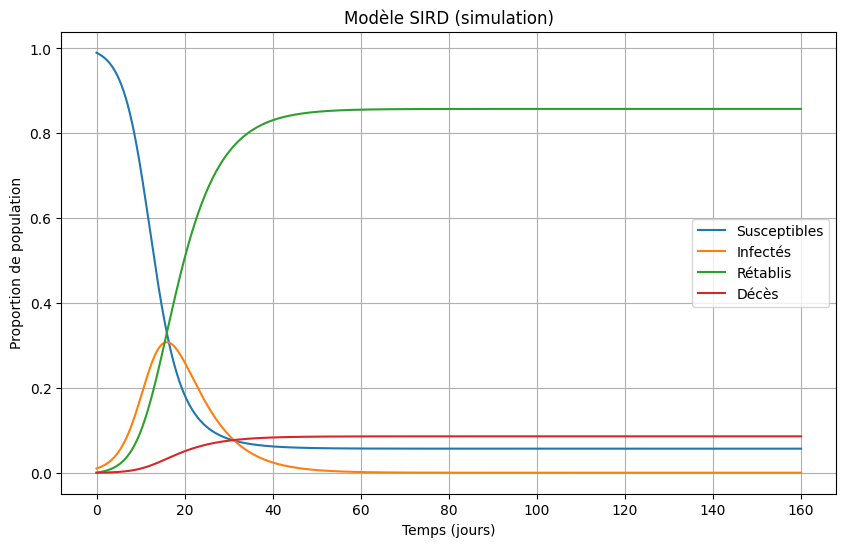

In [31]:
# Paramètres initiaux
beta, gamma, mu = 0.5, 0.15, 0.015
S0, I0, R0, D0 = 0.99, 0.01, 0.0, 0.0
dt = 0.01
days = 160

t, S, I, R, D = euler_sird(beta, gamma, mu, S0, I0, R0, D0, dt, days)

plt.figure(figsize=(10,6))
plt.plot(t, S, label="Susceptibles")
plt.plot(t, I, label="Infectés")
plt.plot(t, R, label="Rétablis")
plt.plot(t, D, label="Décès")
plt.xlabel("Temps (jours)")
plt.ylabel("Proportion de population")
plt.title("Modèle SIRD (simulation)")
plt.legend()
plt.grid()
plt.show()



In [32]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from itertools import product


## Étape 3 : Ajustement des paramètres à partir des données empiriques

In [33]:
sird_data = pd.read_csv("sird_dataset.csv")

# Affichage des premières lignes et des noms de colonnes pour vérification
sird_data.head(), sird_data.columns.tolist()


(   Jour  Susceptibles  Infectés  Rétablis     Décès
 0     0      0.998894  0.003197 -0.002455 -0.004622
 1     1      0.991526  0.000409  0.010702  0.008857
 2     2      0.982164  0.011018  0.004865 -0.001515
 3     3      0.988132  0.008969 -0.006308  0.003571
 4     4      0.971090  0.007307  0.005403  0.004894,
 ['Jour', 'Susceptibles', 'Infectés', 'Rétablis', 'Décès'])

Meilleurs paramètres : β=0.5, γ=0.15, μ=0.005 avec MSE=0.23687


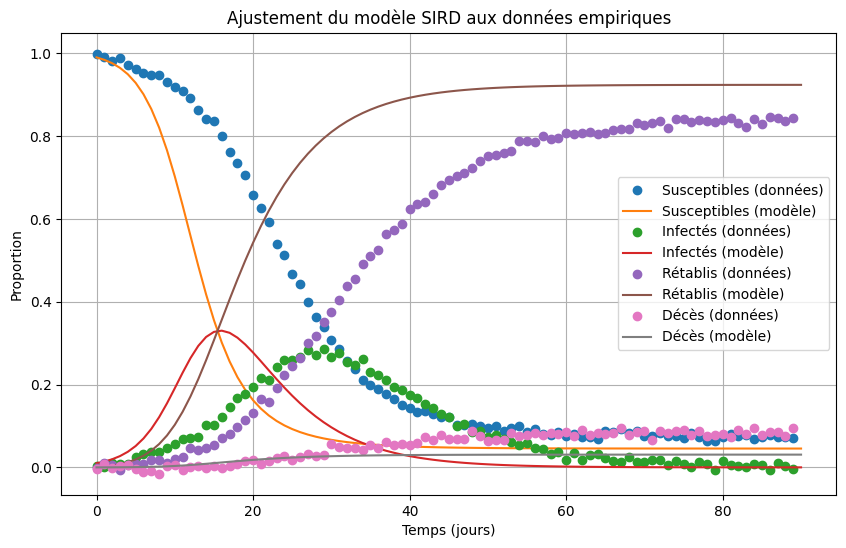

In [ ]:
# Fonction d’évaluation (MSE)
def cost_function(params):
    beta, gamma, mu = params
    t_model, S, I, R, D = euler_sird(beta, gamma, mu, S0, I0, R0, D0, dt, len(df_data))
    
    # Prendre seulement les premiers n points correspondant à la taille du dataset
    idx = np.arange(0, len(df_data))  # par exemple 0 à 89 si 90 lignes
    
    S, I, R, D = S[idx], I[idx], R[idx], D[idx]

    mse = (
        mean_squared_error(df_data["Susceptibles"], S) +
        mean_squared_error(df_data["Infectés"], I) +
        mean_squared_error(df_data["Rétablis"], R) +
        mean_squared_error(df_data["Décès"], D)
    ) / 4
    return mse


# Grid Search
beta_vals = np.linspace(0.25, 0.5, 6)
gamma_vals = np.linspace(0.08, 0.15, 8)
mu_vals = np.linspace(0.005, 0.015, 6)

best_params = None
best_score = float('inf')

for beta_, gamma_, mu_ in product(beta_vals, gamma_vals, mu_vals):
    mse = cost_function((beta_, gamma_, mu_))
    if mse < best_score:
        best_score = mse
        best_params = (beta_, gamma_, mu_)

print(f"Meilleurs paramètres : β={best_params[0]}, γ={best_params[1]}, μ={best_params[2]} avec MSE={best_score:.5f}")

# Visualisation des résultats optimaux

t_fit, S_fit, I_fit, R_fit, D_fit = euler_sird(*best_params, S0, I0, R0, D0, dt, len(df_data))
idx = np.arange(0, len(t_fit), int(1/dt))

plt.figure(figsize=(10,6))
plt.plot(df_data["Susceptibles"], 'o', label="Susceptibles (données)")
plt.plot(S_fit[idx], '-', label="Susceptibles (modèle)")
plt.plot(df_data["Infectés"], 'o', label="Infectés (données)")
plt.plot(I_fit[idx], '-', label="Infectés (modèle)")
plt.plot(df_data["Rétablis"], 'o', label="Rétablis (données)")
plt.plot(R_fit[idx], '-', label="Rétablis (modèle)")
plt.plot(df_data["Décès"], 'o', label="Décès (données)")
plt.plot(D_fit[idx], '-', label="Décès (modèle)")
plt.xlabel("Temps (jours)")
plt.ylabel("Proportion")
plt.title("Ajustement du modèle SIRD aux données empiriques")
plt.legend()
plt.grid()
plt.show()



## Étape 4 : Analyse de R₀ et scénario d'intervention

### 1. Interprétation intuitive du R₀

R₀ = β / (γ + μ)

- Si R₀ > 1 : chaque infecté infecte en moyenne plus d'une personne → épidémie s’étend.
- Si R₀ < 1 : chaque infecté en infecte moins d'une → épidémie s’éteint avec le temps.


R₀ = 3.23


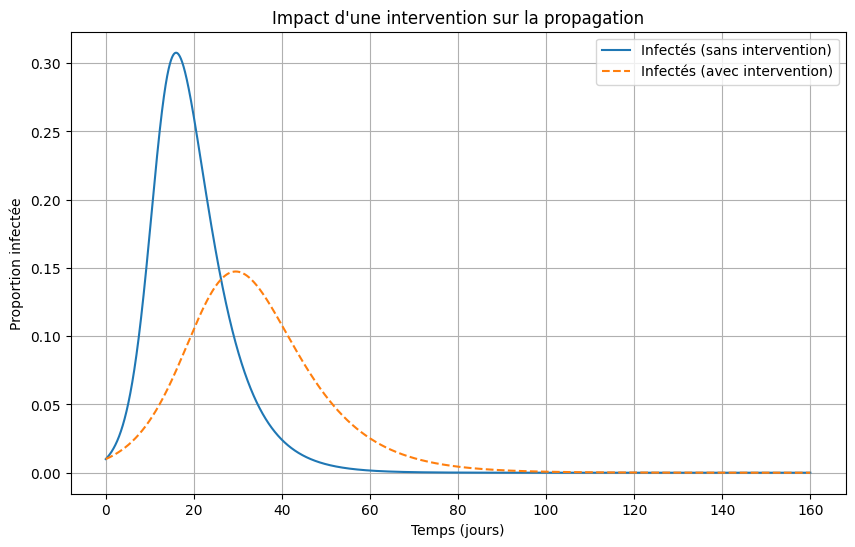

In [35]:
R0 = best_params[0] / (best_params[1] + best_params[2])
print(f"R₀ = {R0:.2f}")

# Réduction de 40% de β
beta_interv = best_params[0] * 0.6
t_int, S_int, I_int, R_int, D_int = euler_sird(beta_interv, best_params[1], best_params[2], S0, I0, R0, D0, dt, days)

plt.figure(figsize=(10,6))
plt.plot(t, I, label="Infectés (sans intervention)")
plt.plot(t_int, I_int, label="Infectés (avec intervention)", linestyle='--')
plt.xlabel("Temps (jours)")
plt.ylabel("Proportion infectée")
plt.title("Impact d'une intervention sur la propagation")
plt.legend()
plt.grid()
plt.show()


### 3. Analyse de l’impact

#### 1. Réduction du pic des infections
Sans intervention, le nombre d'infectés atteint un pic élevé rapidement.

Avec intervention, le pic est moins haut et décalé dans le temps.

Cela signifie que la maladie se propage moins vite, ce qui peut éviter la surcharge des hôpitaux.

#### 2. Propagation plus lente
L'intervention ralentit la vitesse à laquelle la population passe de S (susceptible) à I (infecté).

Le pic est atteint plus tard : cela donne plus de temps pour réagir (vaccination, renforcement des soins, etc.)

#### 3. Réduction du nombre total de décès
Avec un nombre d’infectés plus faible à chaque instant, le nombre cumulé de décès est réduit.

La composante D(t) augmente plus lentement et moins haut.

#### 4. Moins d’immunisation naturelle
Comme moins de gens sont infectés, moins de personnes deviennent immunisées (R(t) plus bas).

Cela signifie qu’on atteint moins facilement l’immunité collective par infection.

#### Conclusion
L’intervention permet de "répartir" l’épidémie dans le temps, de réduire le pic d’infections, et de sauver des vies en limitant les décès.
Même si cela allonge légèrement la durée de l’épidémie, le système de santé a plus de chances de tenir le choc.